## AutoGIS exercise 5

#### Code to create a static map

In [1]:
# importing necessary modules
import requests
import geojson
from pyproj import CRS
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

In [2]:
# Read population grid data for 2018 into a variable `pop`. 
# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [3]:
# Defining the crs
pop.crs = CRS.from_epsg(3879)

In [4]:
# Importing more data
# Filepaths
roads_fp = "data/roads.shp"
metro_fp = "data/metro.shp"

# Read files
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

In [5]:
# Reprojecting geometries for later use with basemap
roads = roads.to_crs(crs=3857)
metro = metro.to_crs(crs=3857)
pop = pop.to_crs(crs=3857)

In [6]:
# Check if coordinate systems match
assert roads.crs == metro.crs, 'Coordinate systems do not match'
assert roads.crs == pop.crs, 'Coordinate systems do not match'

In [7]:
# Check CRS names
print("Roads crs:", CRS(roads.crs).name)
print("Metro crs:", CRS(metro.crs).name)
print("Pop crs: ",CRS(pop.crs).name)

Roads crs: WGS 84 / Pseudo-Mercator
Metro crs: WGS 84 / Pseudo-Mercator
Pop crs:  WGS 84 / Pseudo-Mercator


In [8]:
# renaming columns
pop = pop.rename(columns={'ika0_9': 'age_0-9', 'ika10_19': 'age_10-19', 'ika20_29': 'age_20-29', 'ika30_39': 'age_30-39', 'ika40_49': 'age_40-49', 'ika50_59': 'age_50-59', 'ika60_69': 'age_60-69', 'ika70_79': 'age_70-79', 'ika_yli80': 'age_80+'})

In [9]:
# Defining median age category for each population grid
pop['median_ika'] = ''
for i in range(len(pop)):
    ika = []
    for k in range(4,13,1):
        ika += pop.iloc[i, k] * [pop.columns[k]]
    pop.loc[i, 'median_ika'] = ika[int(len(ika)/2)]

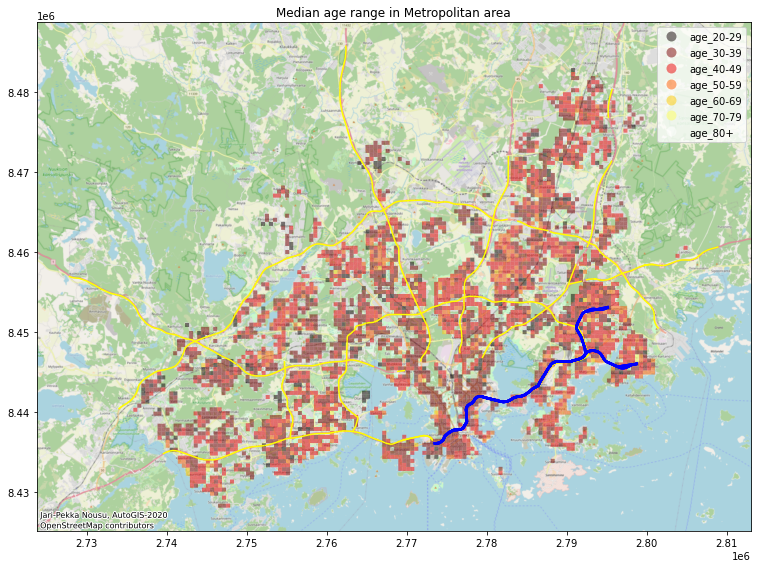

In [10]:
credits = "Jari-Pekka Nousu, AutoGIS-2020\nOpenStreetMap contributors"

# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(12,8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
pop.plot(ax=ax, column='median_ika', cmap='hot', linewidth=0.03, legend = True, alpha=0.5)
ax.set_title('Median age range in Metropolitan area')

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="yellow", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=ax, color="blue", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Adding a basemap
ctx.add_basemap(ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik)

# Save the figure as png file with resolution of 300 dpi
myfp = r'docs/'
figname = "static_map.png"
outfp = os.path.join(myfp, figname)
plt.savefig(outfp, dpi=200)